In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay


In [2]:
# Loading dataset
df = pd.read_csv("https://archive.ics.uci.edu/static/public/601/data.csv")
df.head()

,UID,Product ID,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [3]:
df.describe()

,UID,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [4]:
df.isnull().sum()

UID                    0
Product ID             0
Type                   0
Air temperature        0
Process temperature    0
Rotational speed       0
Torque                 0
Tool wear              0
Machine failure        0
TWF                    0
HDF                    0
PWF                    0
OSF                    0
RNF                    0
dtype: int64

In [5]:
# Feature Engineering
X = df.drop(['UID', 'Product ID', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1)
y = df['Machine failure']

X['Temperature difference'] = X['Process temperature'] - X['Air temperature']
X = X.drop(['Process temperature', 'Air temperature'], axis=1)

X.head()

,Type,Rotational speed,Torque,Tool wear,Temperature difference
0,M,1551,42.8,0,10.5
1,L,1408,46.3,3,10.5
2,L,1498,49.4,5,10.4
3,L,1433,39.5,7,10.4
4,L,1408,40.0,9,10.5


In [6]:
# Buat dummy variable untuk kategorisasi feature Type
X = pd.get_dummies(X, columns=['Type'], drop_first=True)

# Standarisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Partisi
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Training model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [7]:
# Evaluasi
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)

report['no failure'] = report.pop('0')
report['failure'] = report.pop('1')

reportdf = pd.DataFrame(report).transpose()
reportdf = reportdf.drop(['accuracy'], axis=0)
reportdf

,precision,recall,f1-score,support
macro avg,0.830795,0.637721,0.691743,3000.0
weighted avg,0.968292,0.973667,0.968262,3000.0
no failure,0.977380,0.995872,0.986539,2907.0
failure,0.684211,0.279570,0.396947,93.0


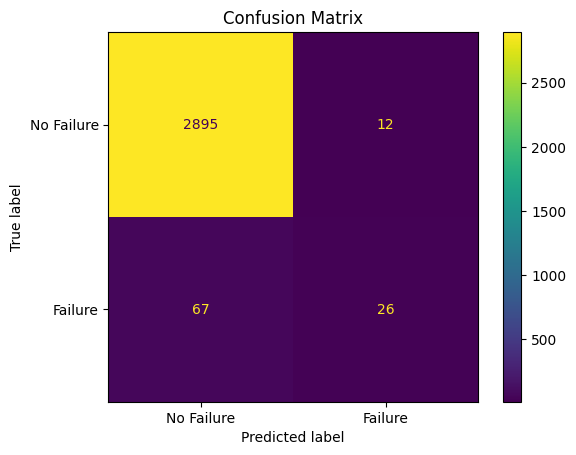

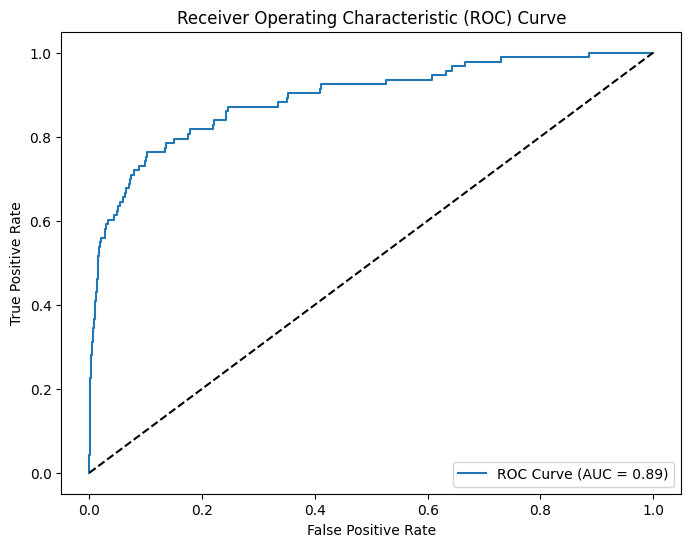

In [8]:
# Evaluasi
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=["No Failure", "Failure"])
cmd.plot()
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

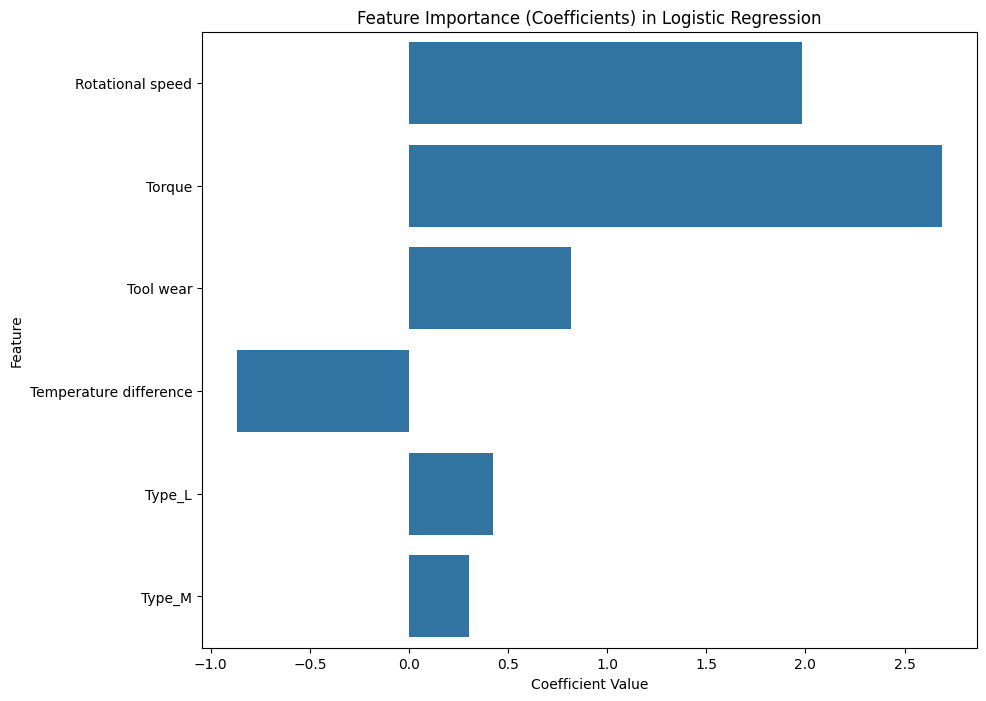

In [9]:
# Feature importance
feature_importance = model.coef_[0]
feature_names = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance, y=feature_names)
plt.title('Feature Importance (Coefficients) in Logistic Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()